# ACP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import math
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.utils import shuffle

## Load the dataset

In [2]:
def load_data_ACP(choice=0):
    if choice:
        data_dir = 'Data/64'
        image_list = []
        target_list = []
        target = 0
        for subdir, dirs, files in os.walk(data_dir):
            for file in files:
                target_list.append(target)
                file_path = os.path.join(subdir, file)
                try:
                    with Image.open(file_path) as img:
                        # Supprimer la conversion en noir et blanc
                        img_array = np.array(img)
                        image_list.append(img_array)
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
            target += 1
        return (np.array(image_list), np.array(target_list)), (None, None)
    else:
        return keras.datasets.mnist.load_data()

## This section is in case we need to test it with an actual library

In [3]:
def compare_pca(data, target):
    data = data.reshape((data.shape[0], -1))
    pca_2d = PCA(n_components=2, whiten=True)
    X_pca_2d = pca_2d.fit_transform(data)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=target, cmap='viridis', edgecolor='k', s=40)
    plt.colorbar(scatter)
    plt.title('MNIST Digits PCA (2D)')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.show()

    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(data)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=target, cmap='viridis', edgecolor='k', s=40)
    ax.set_title('MNIST Digits PCA (3D)')
    ax.set_xlabel('Composante Principale 1')
    ax.set_ylabel('Composante Principale 2')
    ax.set_zlabel('Composante Principale 3')
    fig.colorbar(scatter)
    plt.show()

## If we want to standardized with the global dataset

In [4]:
def standardized_global(x_train):
    means = x_train.values.mean()
    std = x_train.values.std()
    df_train_centered = (x_train - means) / std

    return df_train_centered, std, means

## If we want to standardized with the pixels dataset

In [5]:
def standardized_by_pixels(x_train):
    means = x_train.mean(axis=0)
    std = x_train.std(axis=0, ddof=0)
    epsilon = 1e-8
    std[std == 0] = epsilon
    x_train = (x_train - means)/std
    return x_train, std, means

## Generate Data? Tried something

In [6]:
def generate(df_centered, eig_vectors_sorted, std, means, k=80):
    principal_components = eig_vectors_sorted[:, :k]
    df_reduced = np.dot(df_centered, principal_components)
    mean_reduced = np.mean(df_reduced, axis=0)
    cov_reduced = np.cov(df_reduced, rowvar=False)
    new_data_reduced = np.random.multivariate_normal(mean_reduced, cov_reduced)
    decoded_images = np.dot(new_data_reduced, principal_components.T)
    decoded_images = decoded_images * std + means
    return decoded_images

## Decode the compressed data

In [7]:
def decode(df_centered, eig_vectors_sorted, std, means, k=80):
    principal_components = eig_vectors_sorted[:, :k]
    df_reduced = np.dot(df_centered, principal_components)
    decoded_images = np.dot(df_reduced, principal_components.T)
    decoded_images = decoded_images * std + means
    return decoded_images

## Viz 2D

In [8]:
def viz_2D(df_centered, target, title):
    k = 2
    principal_components = eig_vectors_sorted[:, :k]
    df_reduced = np.dot(df_centered, principal_components)
    np.clip(df_reduced, 0, 255)
    plt.figure(figsize=(8, 6))
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=target, cmap='viridis', s=2)
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.title(title)
    plt.colorbar()
    plt.show()

## Viz 3D

In [9]:
def viz_3D(df_centered, target, title):
    k = 3
    principal_components = eig_vectors_sorted[:, :k]
    df_reduced = np.dot(df_centered, principal_components)
    np.clip(df_reduced, 0, 255)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(df_reduced[:, 0], df_reduced[:, 1], df_reduced[:, 2], c=target, cmap='viridis', s=2)
    ax.set_xlabel('Composante principale 1')
    ax.set_ylabel('Composante principale 2')
    ax.set_zlabel('Composante principale 3')
    plt.title(title)
    plt.colorbar(sc)
    plt.show()

## We might need to analyze which K we want to take 

In [10]:
def know_k(eig_values_sorted, target_percent=0.85):
    # Variance en ordonnées et K en abscisse pour connaitre le K à prendre.
    variance_explained = eig_values_sorted / np.sum(eig_values_sorted)
    cumulative_variance_explained = np.cumsum(variance_explained)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, marker='o', linestyle='-', label='Variance cumulée')
    plt.xlabel('Nombre de composantes principales (k)')
    plt.ylabel('Proportion de variance')
    plt.title('Scree Plot')
    plt.legend()
    plt.grid(True)
    plt.show()
    return np.argmax(cumulative_variance_explained > target_percent)

## Show image

In [11]:
def show_img(img, label, dim_number):
    if dim_number == 3:
        img_size = int(math.sqrt(len(img) // 3))
        if len(img) % (img_size * img_size * 3) != 0:
            raise NotImplementedError("Image de taille invalide")
        img = img.reshape(img_size, img_size, 3)
        plt.imshow(img.astype(int))
    elif dim_number == 2:
        img_size = math.isqrt(len(img))
        if len(img) % img_size != 0:
            raise NotImplementedError("Image de taille invalide")
        img = img.reshape(img_size, img_size)
        plt.imshow(img.astype(int), cmap='gray')
    else:
        raise NotImplementedError("Dimensions de l'image anormales")

    plt.title(f"Label: {label}")
    plt.show()

## Now using the algorithm

In [12]:
(x_train, y_train), (_, _) = load_data_ACP(0)
dim_number = len(x_train.shape) - 1
x_train, y_train = shuffle(x_train, y_train, random_state=0)

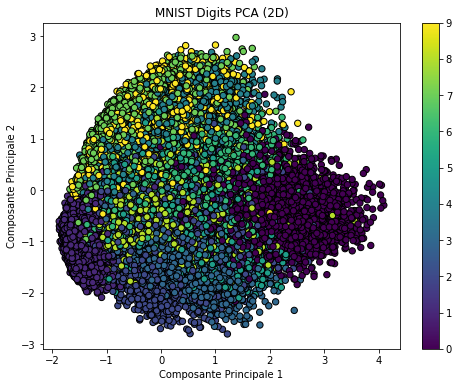

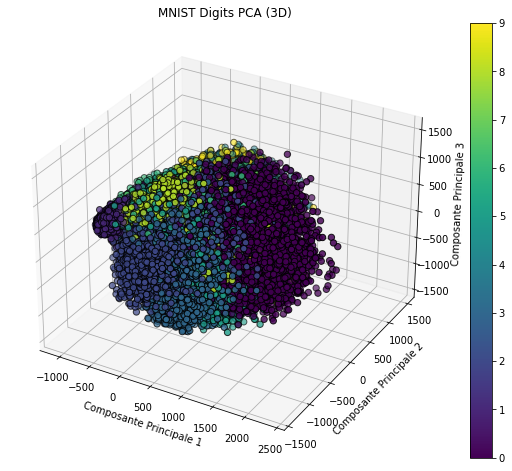

In [13]:
compare_pca(x_train, y_train)

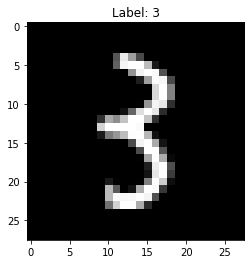

In [14]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(int)
target = y_train.astype(int)
show_img(x_train[0], target[0], dim_number)

In [15]:
df_centered, std, means = standardized_by_pixels(x_train)

In [16]:
# df_centered, std, means = standardized_global(x_train)

In [17]:
cov_matrix = np.cov(df_centered, rowvar=False)
eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eig_values)[::-1]
eig_values_sorted = eig_values[sorted_indices]
eig_vectors_sorted = eig_vectors[:, sorted_indices]

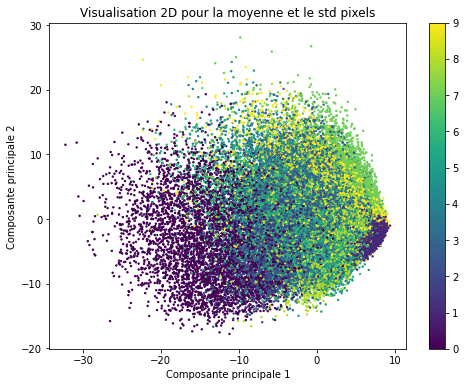

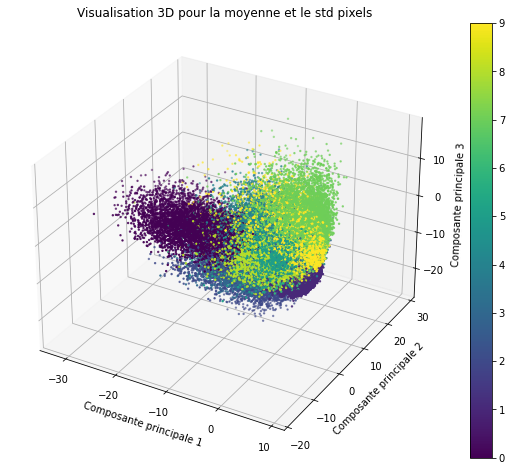

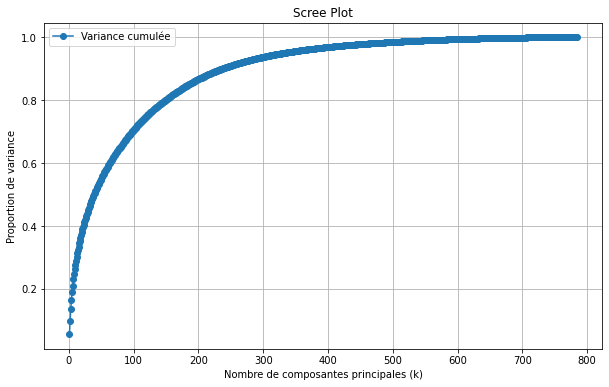

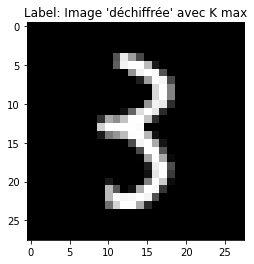

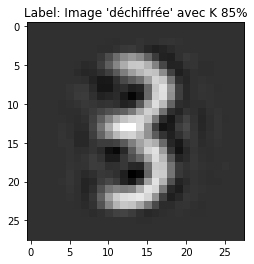

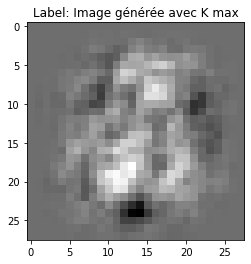

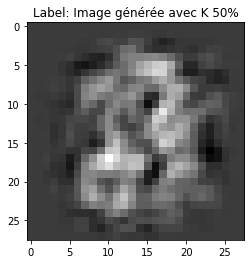

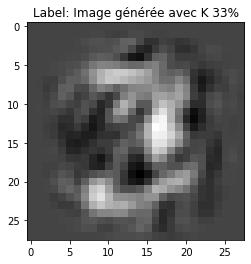

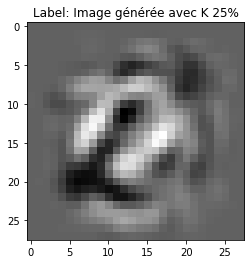

In [18]:
viz_2D(df_centered, target, "Visualisation 2D pour la moyenne et le std pixels")
viz_3D(df_centered, target, "Visualisation 3D pour la moyenne et le std pixels")
k = know_k(eig_values_sorted, 0.85)
decoded_images = decode(df_centered, eig_vectors_sorted, std, means, eig_vectors_sorted.shape[0])
show_img(decoded_images[0], "Image 'déchiffrée' avec K max", dim_number)
decoded_images = decode(df_centered, eig_vectors_sorted, std, means, k)
show_img(decoded_images[0], "Image 'déchiffrée' avec K 85%", dim_number)
decoded_images = generate(df_centered, eig_vectors_sorted, std, means, eig_vectors_sorted.shape[0])
show_img(decoded_images, "Image générée avec K max", dim_number)
decoded_images = generate(df_centered, eig_vectors_sorted, std, means, math.floor(eig_vectors_sorted.shape[0] / 2))
show_img(decoded_images, "Image générée avec K 50%", dim_number)
decoded_images = generate(df_centered, eig_vectors_sorted, std, means, math.floor(eig_vectors_sorted.shape[0] / 3))
show_img(decoded_images, "Image générée avec K 33%", dim_number)
decoded_images = generate(df_centered, eig_vectors_sorted, std, means, math.floor(eig_vectors_sorted.shape[0] / 4))
show_img(decoded_images, "Image générée avec K 25%", dim_number)